<a href="https://colab.research.google.com/github/boomyun713/114_homework/blob/main/%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8CGemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
tickers = ['VST', 'APP', 'NVDA', 'LLY']
start_date = '2021-01-01'
end_date = '2025-11-30'
split_date = '2024-12-31'

In [6]:
def add_indicators(df):
    df = df.copy()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()

    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    return df.dropna()

In [7]:
data = {}
print("正在下載資料並計算指標...")

for ticker in tickers:

    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if not df.empty:

        if isinstance(df.columns, pd.MultiIndex):
            df = df.xs(ticker, axis=1, level=1)

        df_processed = add_indicators(df)
        data[ticker] = df_processed
    else:
        print(f"Error downloading {ticker}")

print("資料處理完成。")

正在下載資料並計算指標...
資料處理完成。


/tmp/ipython-input-3972729369.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3972729369.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3972729369.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-3972729369.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


In [8]:
model_predictions = {}
feature_cols = ['MA20', 'MA50', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']

print("\n開始訓練模型 (Training Phase: 2021-2024)...")

for ticker, df in data.items():
    train_data = df[df.index <= split_date]
    test_data = df[df.index > split_date]

    if len(train_data) > 0:
        X_train = train_data[feature_cols]
        y_train = train_data['Target']

        model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)
        model.fit(X_train, y_train)

        last_day_2024 = X_train.iloc[[-1]]
        prediction_prob = model.predict_proba(last_day_2024)[0][1]

        if len(test_data) > 0:
            start_price_2025 = test_data['Open'].iloc[0]
            end_price_2025 = test_data['Close'].iloc[-1]
            actual_return_2025 = ((end_price_2025 - start_price_2025) / start_price_2025) * 100
        else:
            actual_return_2025 = 0

        model_predictions[ticker] = {
            'Model_Optimism_Score': prediction_prob * 100,
            'Actual_2025_Return': actual_return_2025,
            'Test_Data': test_data
        }


開始訓練模型 (Training Phase: 2021-2024)...


In [9]:
results_df = pd.DataFrame(model_predictions).T
results_df = results_df[['Model_Optimism_Score', 'Actual_2025_Return']]
results_df = results_df.sort_values(by='Model_Optimism_Score', ascending=False)

print("\n---------- 分析報告 ----------")
print(f"模型訓練區間: {start_date} 至 {split_date}")
print(f"實際驗證區間: 2025-01-01 至 {end_date}")
print("\n[模型預測 vs 2025實際表現]")
print(results_df)


---------- 分析報告 ----------
模型訓練區間: 2021-01-01 至 2024-12-31
實際驗證區間: 2025-01-01 至 2025-11-30

[模型預測 vs 2025實際表現]
     Model_Optimism_Score Actual_2025_Return
VST             63.310056          28.617985
NVDA            62.623334          30.175413
APP             61.350057          81.078954
LLY             43.481619          38.804203


In [10]:
top_pick = results_df.index[0]
print(f"\n★ 模型在 2024 年底最樂觀的標的是: {top_pick} (信心分數: {results_df.loc[top_pick, 'Model_Optimism_Score']:.2f}%)")


★ 模型在 2024 年底最樂觀的標的是: VST (信心分數: 63.31%)


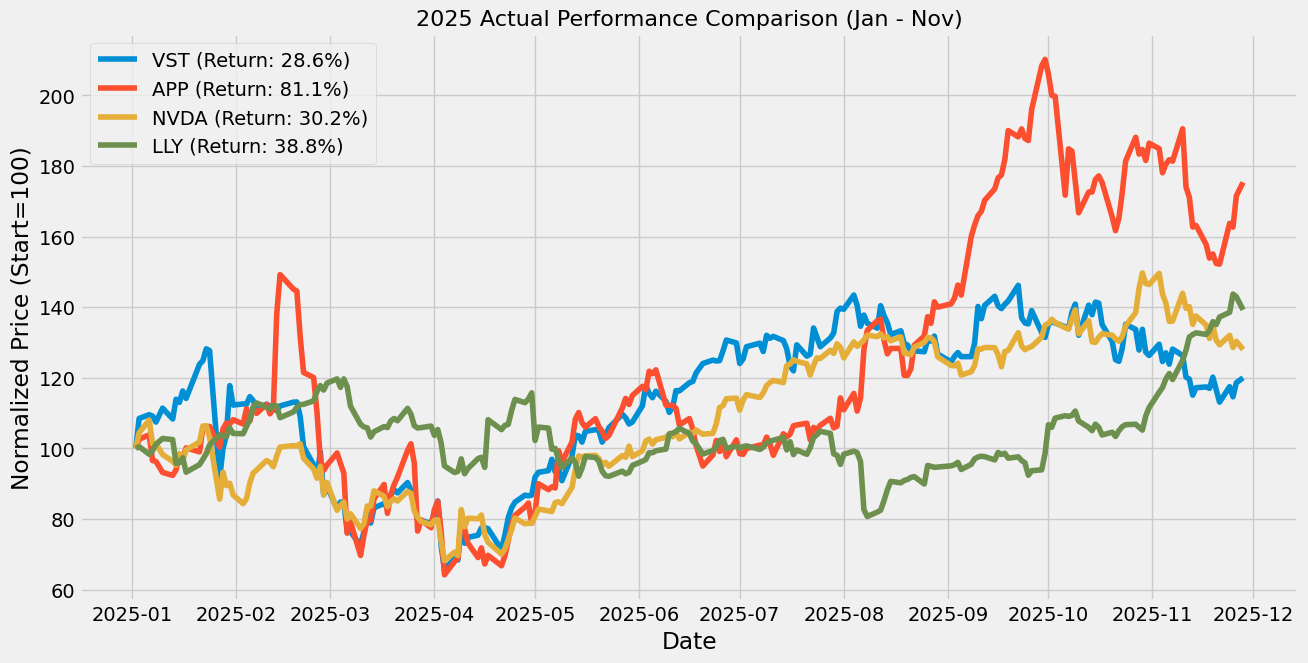

In [12]:
plt.figure(figsize=(14, 7))

for ticker in tickers:
    df_test = data[ticker][data[ticker].index > split_date]
    normalized_price = (df_test['Close'] / df_test['Close'].iloc[0]) * 100
    plt.plot(normalized_price.index, normalized_price, label=f'{ticker} (Return: {model_predictions[ticker]["Actual_2025_Return"]:.1f}%)')

plt.title('2025 Actual Performance Comparison (Jan - Nov)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Normalized Price (Start=100)')
plt.legend()
plt.grid(True)
plt.show()